In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('Titanic.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


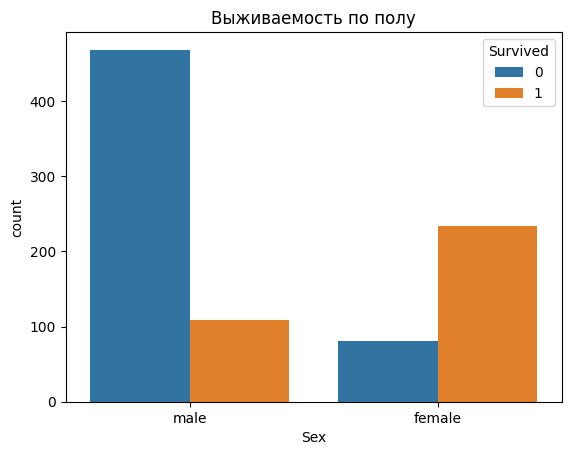

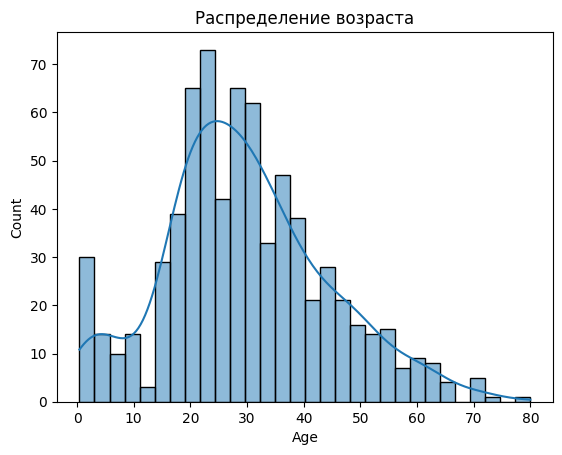

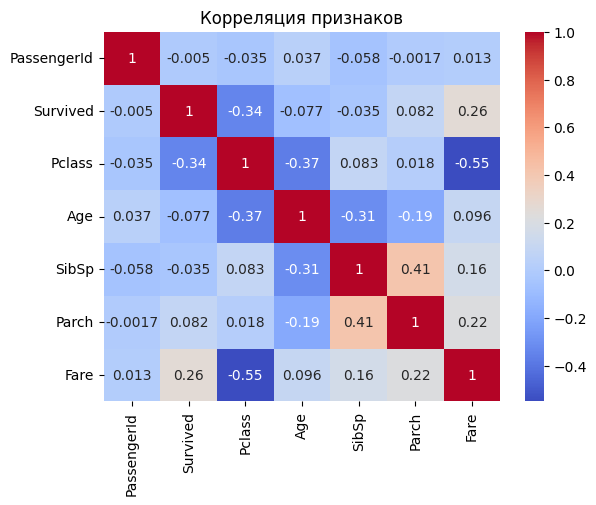

In [2]:
# Проверим пропущенные значения
df.info()
df.isnull().sum()

# Выживаемость по полу
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Выживаемость по полу')
plt.show()

# Распределение возраста
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Распределение возраста')
plt.show()

# Корреляционная матрица
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

In [3]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace(['Mme'], 'Mrs')
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

In [4]:
X = df.drop('Survived', axis=1)
y = df['Survived']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

log_reg = LogisticRegression()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
print("Logistic Regression CV Accuracy: ", log_scores.mean())

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Neural Net (MLP)": MLPClassifier(max_iter=500)
}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.4f}")

Logistic Regression CV Accuracy:  0.8293892411022534
Decision Tree CV Accuracy: 0.7946
Random Forest CV Accuracy: 0.8215
Neural Net (MLP) CV Accuracy: 0.8283


In [5]:
# GridSearchCV для RandomForest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_scaled, y)
print("Best RF Accuracy:", rf_grid.best_score_)
print("Best RF Params:", rf_grid.best_params_)

# GridSearchCV для MLP
mlp_params = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
}
mlp_grid = GridSearchCV(MLPClassifier(max_iter=1000), mlp_params, cv=5, scoring='accuracy', n_jobs=-1)
mlp_grid.fit(X_scaled, y)
print("Best MLP Accuracy:", mlp_grid.best_score_)
print("Best MLP Params:", mlp_grid.best_params_)

Best RF Accuracy: 0.8282656455966355
Best RF Params: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}
Best MLP Accuracy: 0.8103634423451134
Best MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64,), 'solver': 'adam'}


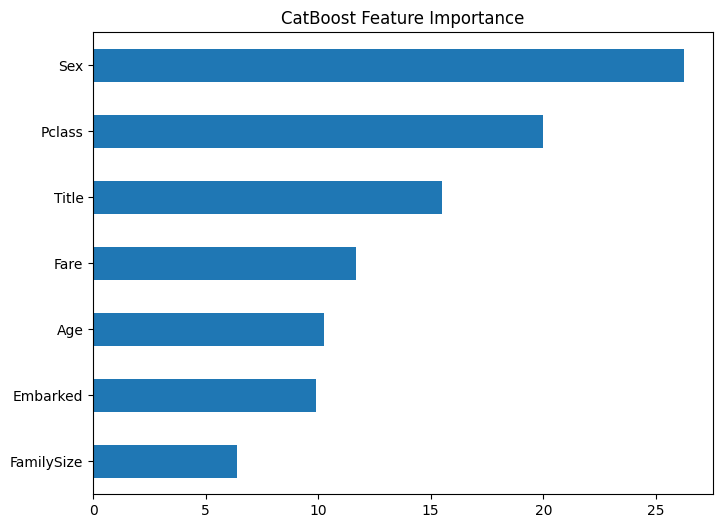

In [7]:
df_cat = pd.read_csv('titanic.csv')
df_cat['Age'] = df_cat['Age'].fillna(df_cat['Age'].median())
df_cat['Embarked'] = df_cat['Embarked'].fillna(df_cat['Embarked'].mode()[0])
df_cat['FamilySize'] = df_cat['SibSp'] + df_cat['Parch'] + 1
df_cat['Title'] = df_cat['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_cat['Title'] = df_cat['Title'].replace(['Mlle', 'Ms'], 'Miss')
df_cat['Title'] = df_cat['Title'].replace(['Mme'], 'Mrs')
df_cat['Title'] = df_cat['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')

cat_features = ['Sex', 'Embarked', 'Title', 'Pclass']
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Title']
df_cat = df_cat[features + ['Survived']]

X_cat = df_cat.drop('Survived', axis=1)
y_cat = df_cat['Survived']

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_cat, y_cat, cat_features=cat_features)

feature_importances = pd.Series(cat_model.get_feature_importance(), index=X_cat.columns).sort_values(ascending=False)
feature_importances.plot(kind='barh', title='CatBoost Feature Importance', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.show()

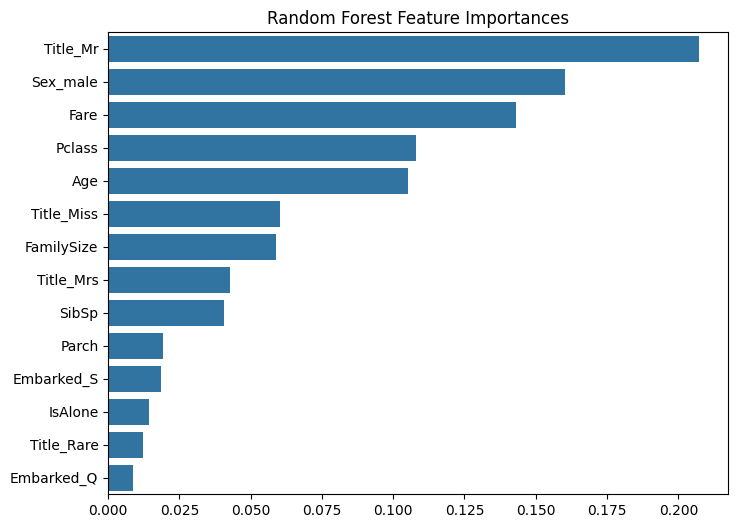

In [6]:
rf_best = rf_grid.best_estimator_
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X.columns

plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=np.array(feat_names)[indices])
plt.title("Random Forest Feature Importances")
plt.show()